## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import Important Implementations

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
from moviepy.editor import VideoFileClip
%matplotlib inline

In [6]:
IMG_SHAPE = (720, 1280, 3)
IMG_SHAPE

(720, 1280, 3)

## Helper Habit

In [7]:
def show_images(images, columns=2, cmap=None):
    rows = math.ceil(len(images)/columns)
    f, axarr = plt.subplots(rows, columns, figsize=(20, rows*4))
    for index, image in enumerate(images):
        x = index % columns
        y = int(index / columns)
        
        if len(axarr.shape) > 1:
            axarr[y, x].imshow(image, cmap=cmap)
        else:
            axarr[x].imshow(image, cmap=cmap)

## Compute Camera Calibration

In [8]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

In [9]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, IMG_SHAPE[1::-1], None, None)

# This function has state... Shhhh...  Don't tell anyone
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

#### Example:

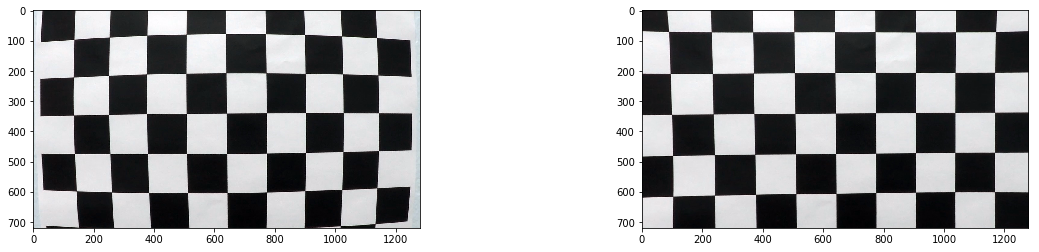

In [10]:
img = cv2.imread('./camera_cal/calibration1.jpg')

show_images([img, undistort(img)])

In [11]:
def warp(img, undo=False):
    
    img_size = (img.shape[1], img.shape[0])
    size = img.shape
    
    dst_offset = 300
    dst = np.float32([
        (size[1]/2-dst_offset, 0), 
        (size[1]/2+dst_offset, 0), 
        (size[1]/2+dst_offset, 720), 
        (size[1]/2-dst_offset, 720)
    ])
    
    src_top_offset = 45
    src_bottom_offset = 450
    src = np.float32([
        (int(size[1]/2-src_top_offset), 450), 
        (int(size[1]/2+src_top_offset), 450), 
        (int(size[1]/2+src_bottom_offset), 720),
        (int(size[1]/2-src_bottom_offset), 720)
    ])
    
    
    if not undo:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    
    return warped, M

In [12]:
def binerize(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(50, 255), alt=False):
    #img = cv2.blur(img.copy(), (20,20))
    img = img.copy()
    
    # Convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel xls
    #l_blur = cv2.blur(l_channel, (10, 0))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=15)
    
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, np.zeros_like(l_binary),)) * 255
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    
    return binary, color_binary

In [13]:
def reduce_noise(gray):
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))

    mask = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

    gray = gray * mask
    return gray

In [14]:
def crop(gray):
    
    size = gray.shape
    
    offset = 350 # A little bigger than dst_offset from warp()
    
    vertices = np.array([
        [
            (0,0),
            (size[1],0),
            (size[1]/2+offset, size[0]),
            (size[1]/2-offset, size[0]), 
        ]
    ],dtype=np.int32)

    mask = np.zeros_like(gray)
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(gray, mask)
    
    return masked_image


In [15]:
def find_lines(binary):
    histogram = np.sum(binary[(binary.shape[0]//2):,:], axis=0)
    midpoint = histogram.shape[0]//2
    
    # Assumes you are in the center of a lane
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = binary.shape[0]//nwindows
    
    nonzeroy, nonzerox = binary.nonzero()
    
    leftx_current = left_peak
    rightx_current = right_peak
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Find pixels in rectangle
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (lefty, leftx), (righty, rightx)

In [16]:
def find_lines_from(binary, left_fit, right_fit):
    nonzeroy, nonzerox = binary.nonzero()

    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Etract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (lefty, leftx), (righty, rightx)

In [17]:
def calculate_curvature(fit_cr, ym_per_pix=(30/720), xm_per_pix=(3.7/700)):
    y_eval = IMG_SHAPE[0]
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1] )**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

In [18]:
def draw_lane(left_fit, right_fit):
    
    ploty = np.linspace(0, IMG_SHAPE[0]-1, IMG_SHAPE[0])
    
    # Create an image to draw the lines on
    color_warp = np.zeros(IMG_SHAPE).astype(np.uint8)
    
    # Calculate points
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (128, 0, 255))
    
    
    return color_warp

def unwarp(undist, color_warp):
    
    unwarp,Minv = warp(img, undo=True)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


In [19]:
# These functions could probably be merged

def calculate_distance(left_fit, right_fit, xm_per_pix=(3.7/700)):
    # Get base of each line
    left_base = left_fit[0]*IMG_SHAPE[0]**2 + left_fit[1]*IMG_SHAPE[0] + left_fit[2]
    right_base = right_fit[0]*IMG_SHAPE[0]**2 + right_fit[1]*IMG_SHAPE[0] + right_fit[2]
    return (right_base - left_base) * xm_per_pix

def calculate_off_center(left_fit, right_fit, xm_per_pix=(3.7/700)):
    # Get base of each line
    left_base = left_fit[0]*IMG_SHAPE[0]**2 + left_fit[1]*IMG_SHAPE[0] + left_fit[2]
    right_base = right_fit[0]*IMG_SHAPE[0]**2 + right_fit[1]*IMG_SHAPE[0] + right_fit[2]
    lines_center = np.mean([left_base, right_base])
    car_center = IMG_SHAPE[1]/2
    return (lines_center - car_center) * xm_per_pix

## Steps Separately

#### Load Lanes

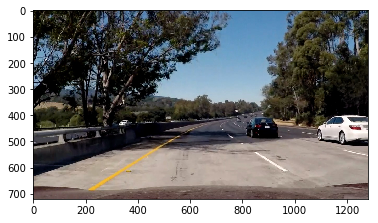

In [20]:
paths = glob.glob('./test_images/*.jpg')

# Load & Convert lanes to RGB
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in paths]

# Pick image to use for examples:
img_original = images[3]
plt.imshow(img_original)

#### 1: Undistort

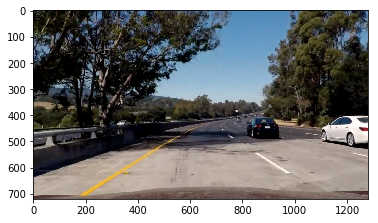

In [21]:
img_undistort = undistort(img_original)
plt.imshow(img_undistort)

#### 2: Warp

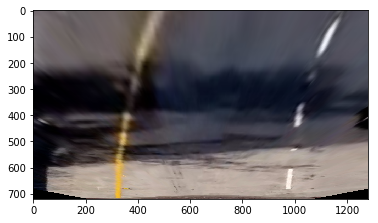

In [22]:
img_warp = warp(img_undistort)[0]    
plt.imshow(img_warp)

#### 3: Binerize

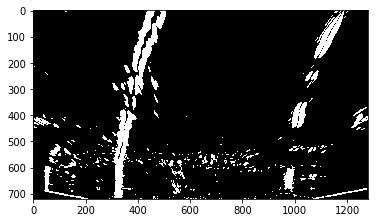

In [23]:
img_binerize = binerize(img_warp)[0]
plt.imshow(img_binerize, cmap='gray')

#### 4: Denoise

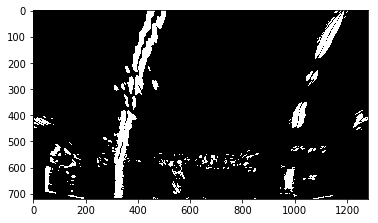

In [24]:
img_denoised = reduce_noise(img_binerize)

plt.imshow(img_denoised, cmap='gray')

#### 5: Crop

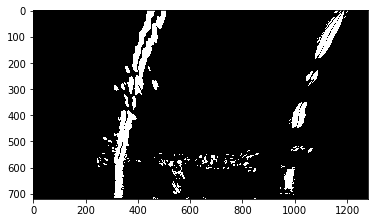

In [25]:
img_cropped = crop(img_denoised)
plt.imshow(img_cropped, cmap='gray')

#### 6: Histogram

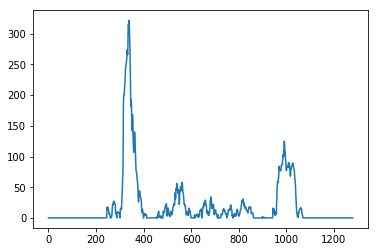

In [26]:
# Take a historgram of the bottom half of the image
histogram = np.sum(img_cropped[(img.shape[0]//2):,:], axis=0)
plt.plot(histogram)

#### 7: Filter
Using the peaks from the histogram above, starting from the bottom, iteritivly slide a filter up the image looking for pixels & re adjusting to center on them.  (Left colored in blue, right colored in red)

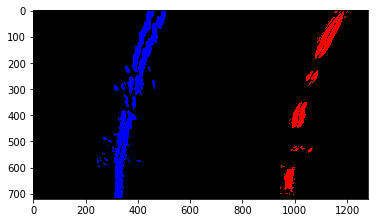

In [33]:
left_fit, right_fit, left_pixels, right_pixels = find_lines(img_cropped)
zeros = np.zeros_like(img_original)
zeros[left_pixels] = [0, 0, 255]
zeros[right_pixels] = [255, 0, 0]

plt.imshow(zeros)

#### 7: Fit
Fit a polynomials to each of the lanes

(720, 0)

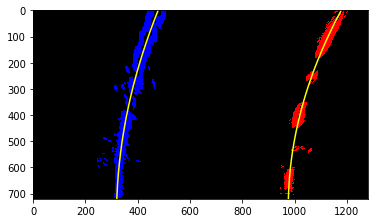

In [34]:
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(zeros)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [36]:
fit = np.copy(left_fit)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

fit[0] = fit[0] * (xm_per_pix)/(ym_per_pix**2)
fit[1] = fit[1] * (xm_per_pix)/(ym_per_pix)
fit[2] = fit[2] * (xm_per_pix)

((1 + (2*fit[0] * (IMG_SHAPE[0] * ym_per_pix) + fit[1])**2)**1.5) / np.absolute(2*fit[0])

In [37]:
IMG_SHAPE[0]

720

#### 7: Draw Lane
Draw the lane between the two polynomials

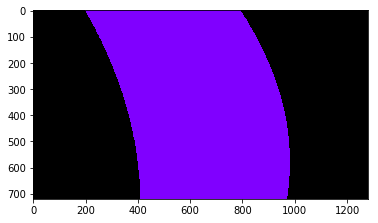

In [25]:
drawn = draw_lane(left_fit, right_fit)

plt.imshow(drawn)

#### 8: Unwarp
Apply a reverse warp function & then overlay it onto the undistorted original image.

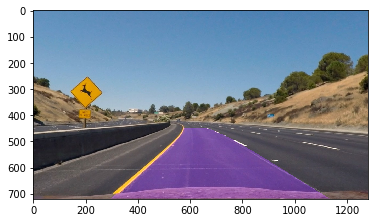

In [26]:
drawn = unwarp(img_undistort, drawn)

plt.imshow(drawn)

## Pipeline 
Here I bring all the steps from above together.  However, here I also store a cache of past few lines found.  This is used to both avoid spikes by averaging the lanes & to provide a sanity check on the new lines.

In [27]:
cache_length = 8
font = cv2.FONT_HERSHEY_DUPLEX
fontColor = (96, 0, 192)

# Values
fails = 0

lines = []
curverads = []

def pipeline(img):
    global fails
    global lines
    global curverads
    
    img_original = img
    img_undistort = undistort(img_original)
    img_warp = warp(img_undistort)[0]
    img_binerize = binerize(img_warp)[0]
    img_denoised = reduce_noise(img_binerize)
    img_cropped = crop(img_denoised)
    
    img_binary = img_cropped
    
    if lines:
        left_fit, right_fit, left_pixels, right_pixels = find_lines_from(img_binary, lines[0][0], lines[0][1])
    else:
        left_fit, right_fit, left_pixels, right_pixels = find_lines(img_binary)
    
    left_curverad = (calculate_curvature(left_fit)/1000)
    right_curverad = (calculate_curvature(right_fit)/1000)
    # Average curve of each line
    curverad_avg = np.mean([left_curverad, right_curverad])
    
    # Sanity Check
    sane = True
    line_distance = calculate_distance(left_fit, right_fit)
    # If left and right curverad is about the same
    if abs(math.atan(left_curverad) - math.atan(right_curverad)) > 0.25:
        sane = False
    # If cuverad is about the same as the last curvard
    if curverads and abs(math.atan(curverads[0]) - math.atan(curverad_avg)) > 0.25:
        sane = False
    # If the distance between the lanes is about 3.5 meters
    if abs(line_distance - 3.5) > 1:
        print('line_distance greater than 1')
        sane = False
    
    
    # If the lines are sane
    if sane:
        # Reset Fails
        fails = 0
        # Add lines to cache
        lines.insert(0, (left_fit, right_fit))
        curverads.insert(0, curverad_avg)
    else:
        # Increase fails
        fails += 1
        #print('Fails: {}'.format(fails))
    
    # Remove old stuff from cache
    cache_amount = (cache_length-fails)
    curverads = curverads[:cache_amount]
    lines = lines[:cache_amount]
    
    # If there are know known sane lines
    if not lines:
        # Just return the undistorted image
        #print('Empty frame')
        cv2.putText(img_undistort, 'No sane lane found', (50, 50), font, 2, fontColor, 2)
        return img_undistort
    
    # Average the lines from the cache
    mean_lines = np.mean(lines, axis=0)
    curverad_avg = np.mean(curverads, axis=0)
    left_fit_avg = mean_lines[0]
    right_fit_avg = mean_lines[1]
    
    off_center = calculate_off_center(left_fit_avg, right_fit_avg)
    
    
    drawn = draw_lane(left_fit_avg, right_fit_avg)
    
    result = unwarp(img_undistort, drawn)
    cv2.putText(result, 'Curverad: {:.2f} km'.format(curverad_avg), (50, 90), font, 2, fontColor, 2)
    cv2.putText(result, 'Off center: {:.2f} m'.format(off_center), (50, 140), font, 2, fontColor, 2)
    return result
    
    
    

## Visualizing Videos

In [28]:
clip = VideoFileClip("project_video.mp4")

out_clip = clip.fl_image(pipeline)

out_clip.write_videofile('./output_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████▉| 1260/1261 [03:23<00:00,  6.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

